# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Note: the above link is dead, the content is here: https://community.alteryx.com/t5/Data-Science/Beginner-s-Guide-to-Customer-Segmentation/ba-p/138442

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
display(df_offers.head())

/Users/deannachurch/opt/anaconda3/envs/Springboard/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,Offer #,Campaign,Varietal,Minimum Qty (kg),Discount (%),Origin,Past Peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


### 1b. Explore the data

In [3]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

/Users/deannachurch/opt/anaconda3/envs/Springboard/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [9]:
#your turn
def create_col_info_df(df):
    """
        Take a dataframe and create a new dataframe containing column information for early EDA 
    """
    missing_values=df.isnull().sum()
    pct_missing = (missing_values/len(df)) * 100
    datatypes = df.dtypes
    unique_values = df.nunique()

    col_info_df = pd.DataFrame({
        "Column name": df.columns,
        "Number of Missing Values": missing_values,
        "Percent Missing Values": pct_missing,
        "Datatype": datatypes,
        "Number of Unique Values": unique_values
    })
    # reset the index
    col_info_df = col_info_df.reset_index(drop=True)
    return (col_info_df)

In [10]:
offers_col_df=create_col_info_df(df_offers)
display(offers_col_df)

,Column name,Number of Missing Values,Percent Missing Values,Datatype,Number of Unique Values
0,offer_id,0,0.0,int64,32
1,campaign,0,0.0,object,12
2,varietal,0,0.0,object,9
3,min_qty,0,0.0,int64,4
4,discount,0,0.0,int64,27
5,origin,0,0.0,object,9
6,past_peak,0,0.0,bool,2


In [11]:
trans_col_df=create_col_info_df(df_transactions)
display(trans_col_df)

,Column name,Number of Missing Values,Percent Missing Values,Datatype,Number of Unique Values
0,customer_name,0,0.0,object,100
1,offer_id,0,0.0,int64,32
2,n,0,0.0,int64,1


In [59]:
print(df_transactions['offer_id'].value_counts())

offer_id
30    22
22    21
8     20
7     19
31    17
29    17
26    15
18    14
11    13
6     12
24    12
4     12
9     10
1     10
2     10
14     9
27     9
10     7
17     7
20     6
3      6
13     6
28     6
25     6
15     6
16     5
23     5
19     5
12     5
32     4
5      4
21     4
Name: count, dtype: int64


No missing data. First, merge dataframes. 

In [13]:
#first, merge dfs
# Merge the DataFrames on the 'offer_id' column
merged_df = pd.merge(df_offers, df_transactions, on='offer_id')
display(merged_df.head(20))

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1
5,1,January,Malbec,72,56,France,False,Price,1
6,1,January,Malbec,72,56,France,False,Foster,1
7,1,January,Malbec,72,56,France,False,Sanders,1
8,1,January,Malbec,72,56,France,False,Butler,1
9,1,January,Malbec,72,56,France,False,Fisher,1


In [20]:
#create a pivot table
pivot_df = merged_df.pivot_table(index='customer_name', columns='offer_id', values='n', fill_value=0)
pivot_df.reset_index(inplace=True)
# Remove the name of the columns index
pivot_df.columns.name = None
display(pivot_df)

,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Williams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
96,Wilson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
97,Wood,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
98,Wright,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [25]:
##checking a couple to make sure things look good
print(df_transactions[df_transactions['customer_name'].isin(['Adams', 'Allen'])])

    customer_name  offer_id  n
102         Allen         9  1
103         Allen        27  1
127         Adams        18  1
128         Adams        29  1
129         Adams        30  1


In [26]:
print(pivot_df[pivot_df['customer_name'].isin(['Adams', 'Allen'])].T)

                   0      1
customer_name  Adams  Allen
1                0.0    0.0
2                0.0    0.0
3                0.0    0.0
4                0.0    0.0
5                0.0    0.0
6                0.0    0.0
7                0.0    0.0
8                0.0    0.0
9                0.0    1.0
10               0.0    0.0
11               0.0    0.0
12               0.0    0.0
13               0.0    0.0
14               0.0    0.0
15               0.0    0.0
16               0.0    0.0
17               0.0    0.0
18               1.0    0.0
19               0.0    0.0
20               0.0    0.0
21               0.0    0.0
22               0.0    0.0
23               0.0    0.0
24               0.0    0.0
25               0.0    0.0
26               0.0    0.0
27               0.0    1.0
28               0.0    0.0
29               1.0    0.0
30               1.0    0.0
31               0.0    0.0
32               0.0    0.0


OK- N=2, but data looks to have been manipulated correctly. 

## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

# Exercise question 1:
What values of $SS$ do you believe represent better clusterings? Why?

You want lower sums of squares. When you are looking at within-cluster $SS$ you want to reduce the number, but not so much that every point is in its own cluster. You want to look for the point in the plot where the slope starts being less dramatic. That is, you have reduced your $SS$ a lot, and upping the K doesn't reduce it 'that' much more. If you reduce it too much, you run the risk of overfitting. 

In [27]:
# your turn
import numpy as np
from sklearn.cluster import KMeans

##create the matrix
offer_columns = pivot_df.columns[1:]
offer_matrix = pivot_df[offer_columns].to_numpy()
print(offer_matrix)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


In [40]:
# Now, i want to cycle through k=2 through k=10 to test values. I want to keep track of the the within cluster SS for plotting. 
from sklearn.cluster import KMeans
#create containers to store some stuff
ss_values=[]
cluster_assign={}

## cycle through to calculate different clusters using different Ks. 
k_range=list(range(2,11))
for K in k_range:
    clust=KMeans(n_clusters=K)
    clust_num=clust.fit_predict(offer_matrix)
    centers=clust.cluster_centers_
    ss_values.append(np.sum((offer_matrix - centers[clust_num]) ** 2))
    cluster_assign[str(K)] = clust_num

print(len(cluster_assign))

9


Text(0.5, 1.0, 'Elbow plot of within cluster SS for offers')

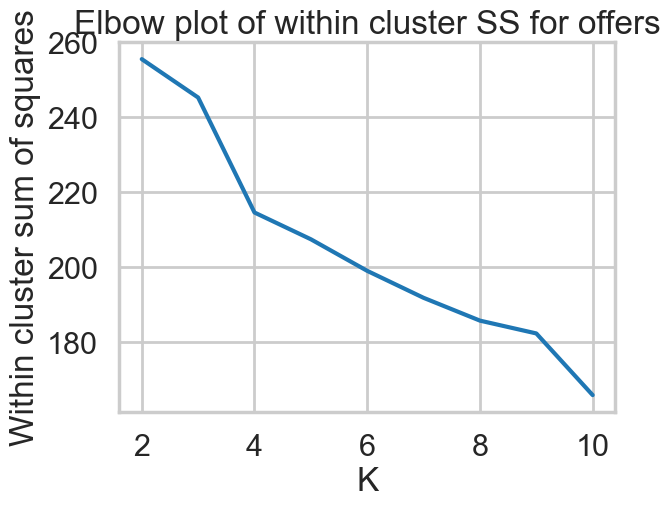

In [42]:
#make the plot

plt.plot(k_range, ss_values)
plt.ylabel("Within cluster sum of squares")
plt.xlabel("K")
plt.title("Elbow plot of within cluster SS for offers")

4


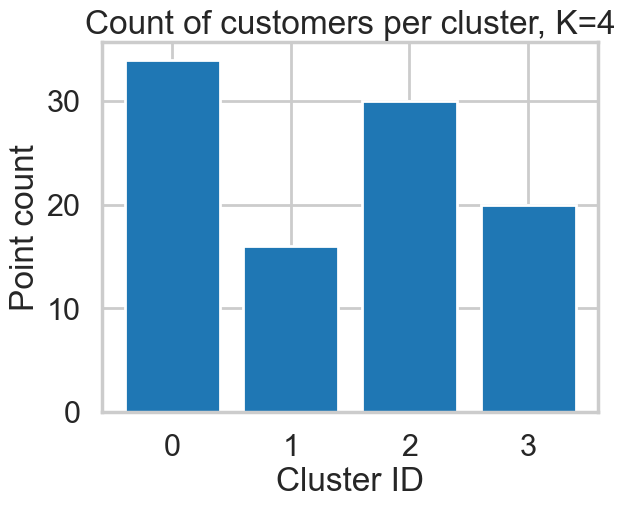

In [45]:
#bar plot
best_K = 4
clust_best_K = cluster_assign[str(best_K)]
cts = np.bincount(clust_best_K)
print(len(cts))

plt.bar(range(best_K), cts, align='center')
plt.xlabel("Cluster ID")
plt.ylabel("Point count")
plt.xticks(range(best_K))
plt.title("Count of customers per cluster, K=4")
plt.show()

# Interpretation

I think K=4 may be the best here. There is a steep drop betwee, 2 and 4, then there is still some drop, but the slope is much more shallow. Between 8 and 10 there is 
another change in slope, which might be tempting to pick, but I'm concerned that is over-fitting. Additionally, the lowest value of SS is still relatively high, which may be concerning. 

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

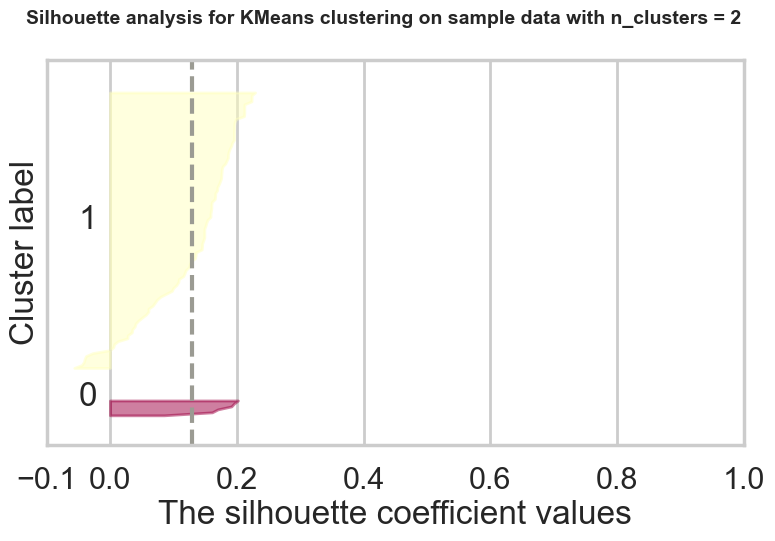

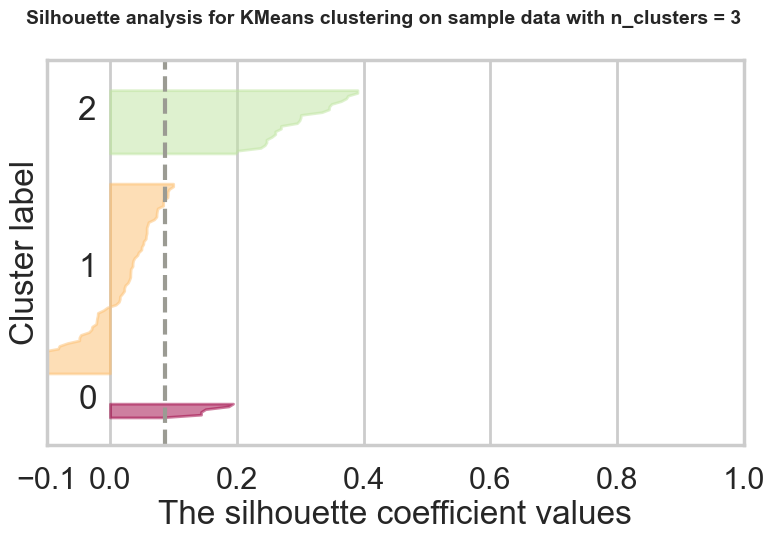

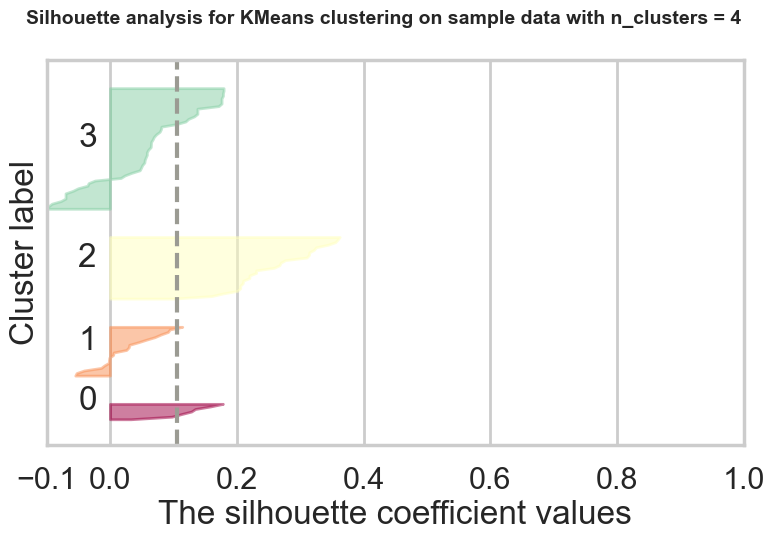

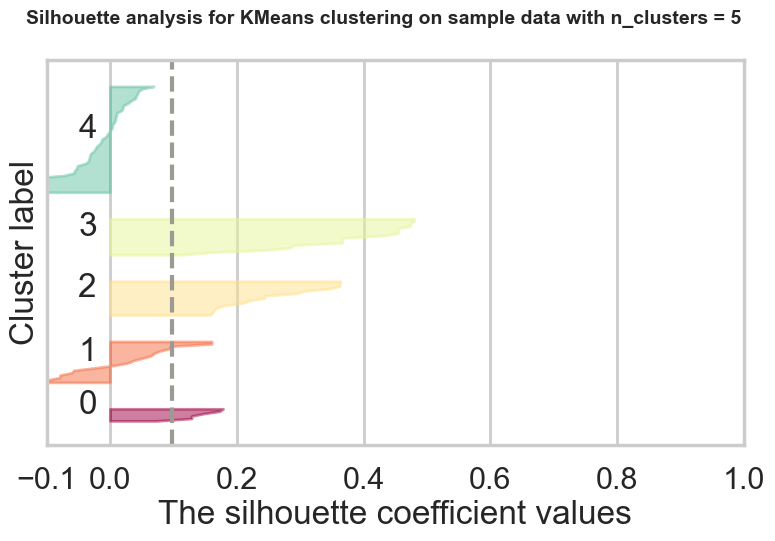

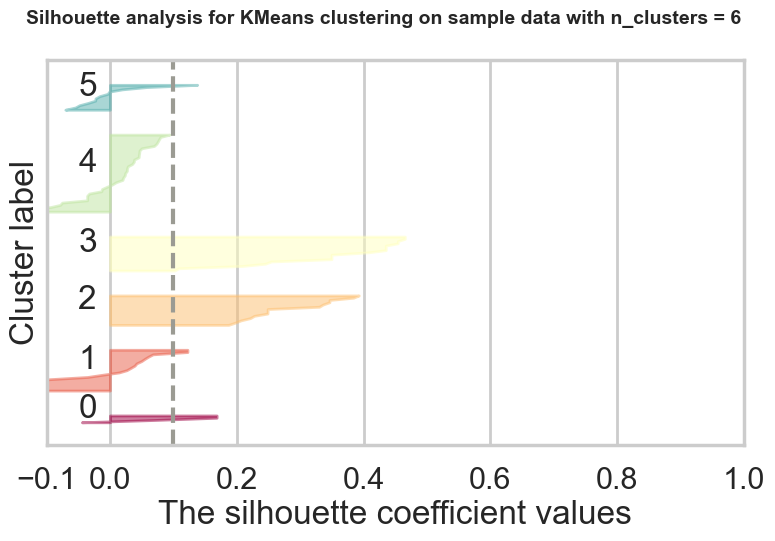

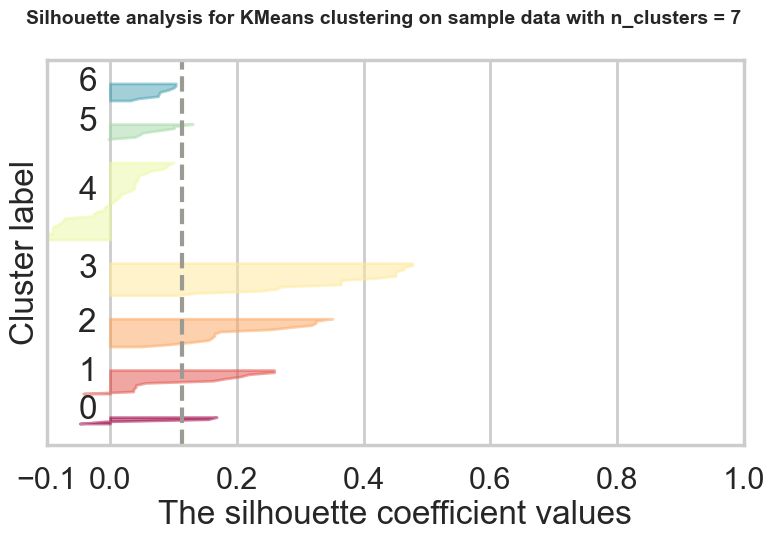

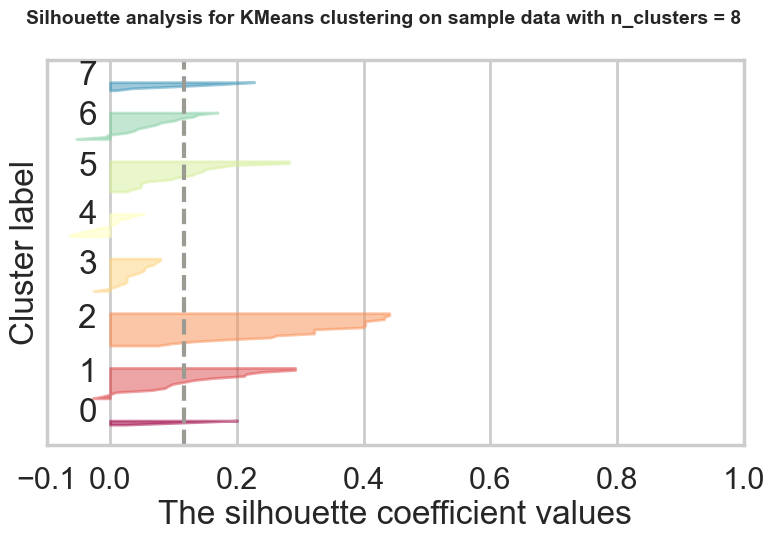

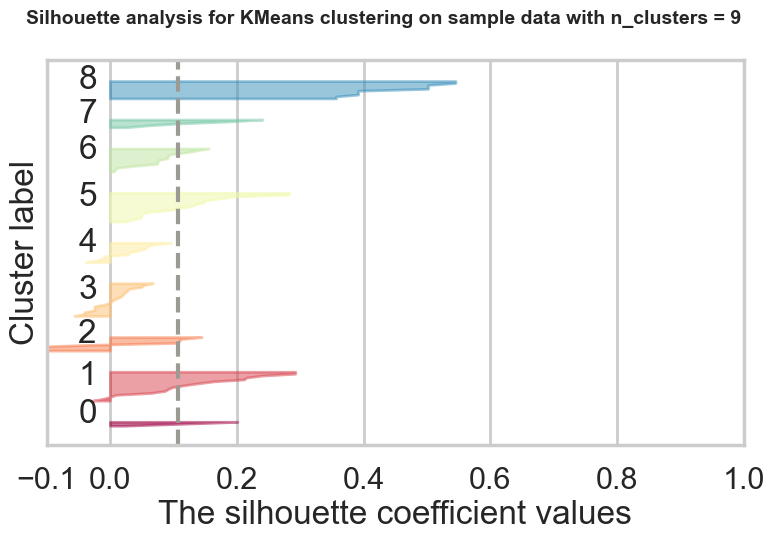

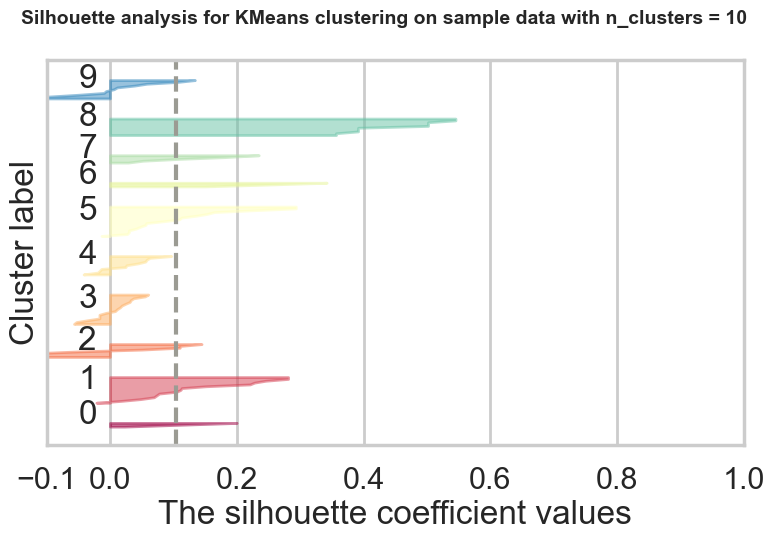

In [125]:
# Your turn.
#relevant imports
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from matplotlib import colormaps

#structure to hold scores
sil_scores=[]

#cycle through to refit models to get scores
for K in k_range:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(9, 5)

    ax1.set_xlim([-0.1, 1]) #potential range of scores
    ax1.set_ylim([0, len(offer_matrix) + (K + 1) * 10])#set y-lim to make clear plots and allow for separation

    #create models
    clust=KMeans(n_clusters=K, random_state=10) #add random_state to make deterministic
    clust_num=clust.fit_predict(offer_matrix)
    
    #calculate and store scores
    score_avg=silhouette_score(offer_matrix, clust_num)
    sil_scores.append(score_avg)

    #get scores for each sample
    samp_sil_scores=silhouette_samples(offer_matrix, clust_num)

    y_lower = 10
    for i in range(K):
        ith_clust_sil_values = samp_sil_scores[clust_num == i]
        ith_clust_sil_values.sort()

        size_cluster_i = ith_clust_sil_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        #cmap = cm.get_cmap("Spectral")
        cmap = colormaps['Spectral']
        color=cmap(float(i) / K)

        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_clust_sil_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.5
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

     # Setting title, xlabel and ylabel 
    #ax1.set_title("The silhouette plot for offer clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    # This requires axvline() 
    ax1.axvline(x=score_avg, color="#9B9B93", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % K),
                 fontsize=14, fontweight='bold')


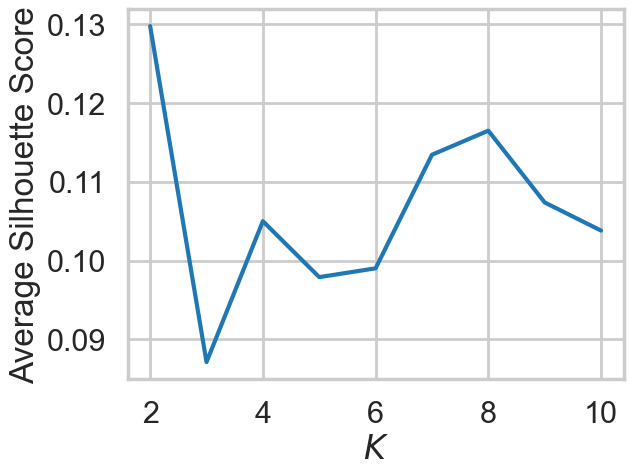

In [57]:
# Call plot() with parameters KRange, avg_silhouette_scores
plt.plot(k_range, sil_scores)
plt.xlabel("$K$")
plt.ylabel("Average Silhouette Score")
plt.show()

The silhouette scores suggests there is no good K, as all of the average scors are <0.25. But, the 'best' K would be 2, which is different from what we got using the within cluster sum of squares. 

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

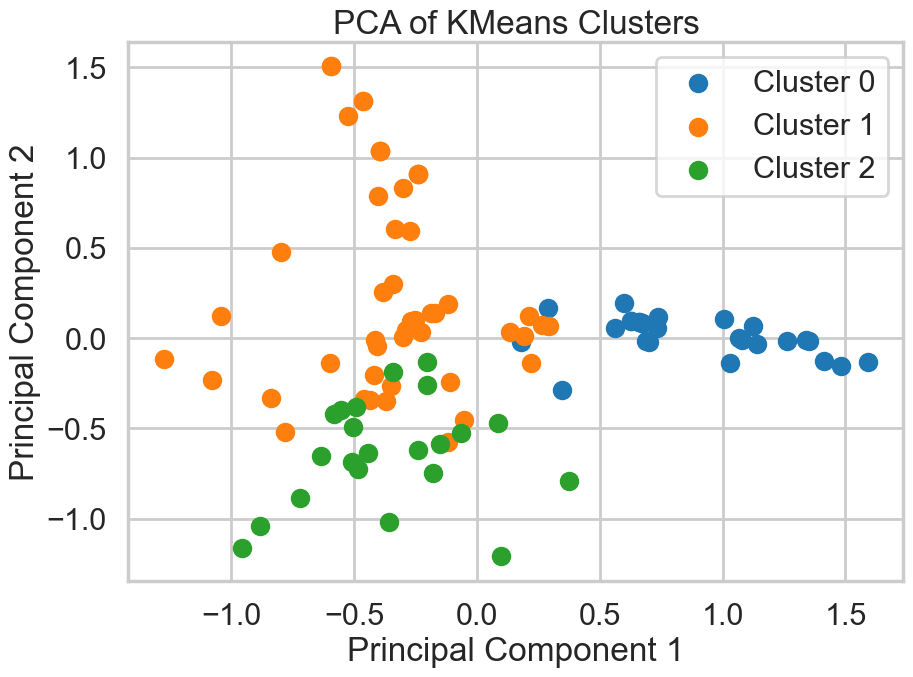

In [66]:
#your turn
#imports
from sklearn.decomposition import PCA

#get your KMeans cluster
model = KMeans(n_clusters = 3)
cluster_assign = model.fit_predict(offer_matrix)

#cmap = cm.get_cmap("tab10")
cmap = colormaps['tab10']

#do PCA on data
pca=PCA(n_components=2)
pc1, pc2 = zip(*pca.fit_transform(offer_matrix))

# Create a scatter plot with a legend
plt.figure(figsize=(10, 7))
for cluster in range(3):
    plt.scatter(
        [pc1[i] for i in range(len(pc1)) if cluster_assign[i] == cluster],
        [pc2[i] for i in range(len(pc2)) if cluster_assign[i] == cluster],
        label=f'Cluster {cluster}',
        color=cmap(cluster)
    )

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of KMeans Clusters')
plt.legend()
plt.show()

In [67]:
#create dataframe
customer_names = pivot_df['customer_name']

df=pd.DataFrame({
    'customer_name': customer_names,
    'cluster_id': cluster_assign,
    'x': pc1,
    'y': pc2
})

display(df)

,customer_name,cluster_id,x,y
0,Adams,0,1.007580,0.108215
1,Allen,1,-0.287539,0.044715
2,Anderson,1,-0.392032,1.038391
3,Bailey,0,0.699477,-0.022542
4,Baker,2,0.088183,-0.471695
...,...,...,...,...
95,Williams,2,-0.151666,-0.587844
96,Wilson,0,0.688224,-0.013688
97,Wood,2,-0.551215,-0.395670
98,Wright,2,-0.489805,-0.383307


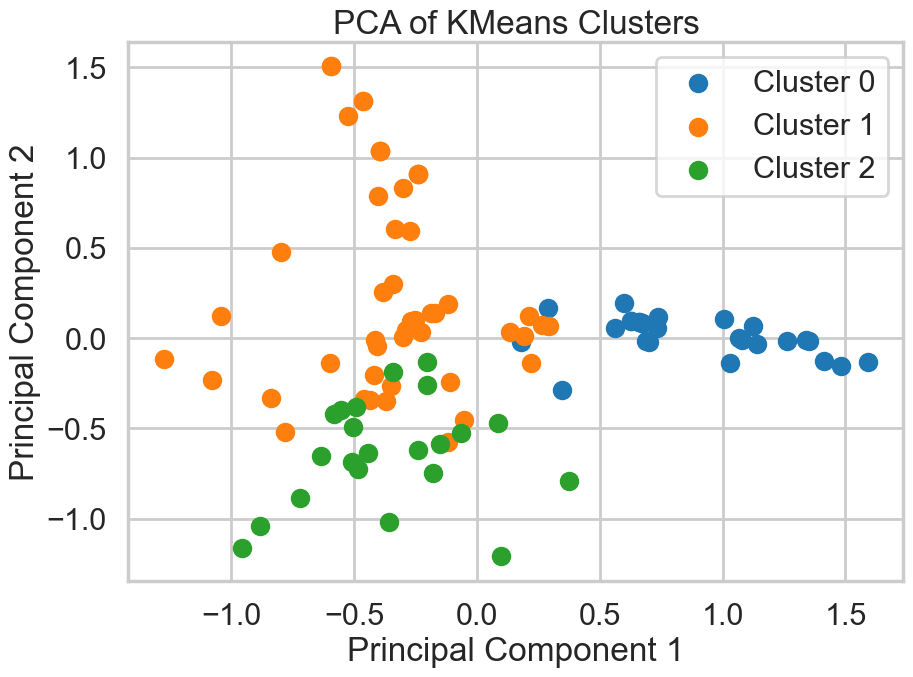

In [68]:
# Create a scatter plot with a legend
plt.figure(figsize=(10, 7))
cmap = colormaps['tab10']
for cluster in range(3):
    cluster_data = df[df['cluster_id'] == cluster]
    plt.scatter(cluster_data['x'], cluster_data['y'], label=f'Cluster {cluster}', color=cmap(cluster))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of KMeans Clusters')
plt.legend()
plt.show()

Looks like I did the same thing twice, just different ways...

In [69]:
print(pca.explained_variance_)

[0.4096489  0.30753551]


The two components roughly explain around 71% of the variance. But PC1 and PC2 are relatively close in the amount of variance they explain on their one (only differing by 10%). 

In [70]:
# Get the components (principal axes)
components = pca.components_

# Create a DataFrame to display the components
features = pivot_df.columns[1:]  # Exclude the 'customer_name' column
pca_df = pd.DataFrame(components, columns=features)

# Print the features driving the two principal components
print("Features driving the first principal component:")
print(pca_df.iloc[0])

print("\nFeatures driving the second principal component:")
print(pca_df.iloc[1])

Features driving the first principal component:
1    -0.161685
2    -0.130215
3    -0.018405
4    -0.175255
5    -0.067120
6    -0.153633
7     0.343673
8     0.332420
9    -0.136168
10   -0.052645
11   -0.161806
12   -0.025638
13    0.180935
14   -0.133907
15   -0.114721
16   -0.032265
17   -0.069694
18    0.271425
19    0.000133
20   -0.093337
21   -0.009546
22   -0.220114
23   -0.079443
24   -0.118974
25   -0.052267
26   -0.222020
27   -0.100333
28   -0.039182
29    0.380350
30    0.406843
31   -0.151940
32   -0.054381
Name: 0, dtype: float64

Features driving the second principal component:
1    -0.082468
2     0.193015
3    -0.116619
4    -0.155288
5    -0.001765
6    -0.265392
7    -0.125241
8    -0.116386
9    -0.051019
10   -0.088837
11   -0.092393
12    0.007062
13   -0.006767
14   -0.089799
15   -0.094877
16    0.007280
17    0.275094
18   -0.009538
19   -0.123051
20   -0.037209
21   -0.058360
22   -0.443740
23   -0.043089
24    0.445111
25   -0.022043
26    0.401641
27   -0.

In [74]:
display(pivot_df)

,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Williams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
96,Wilson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
97,Wood,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
98,Wright,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


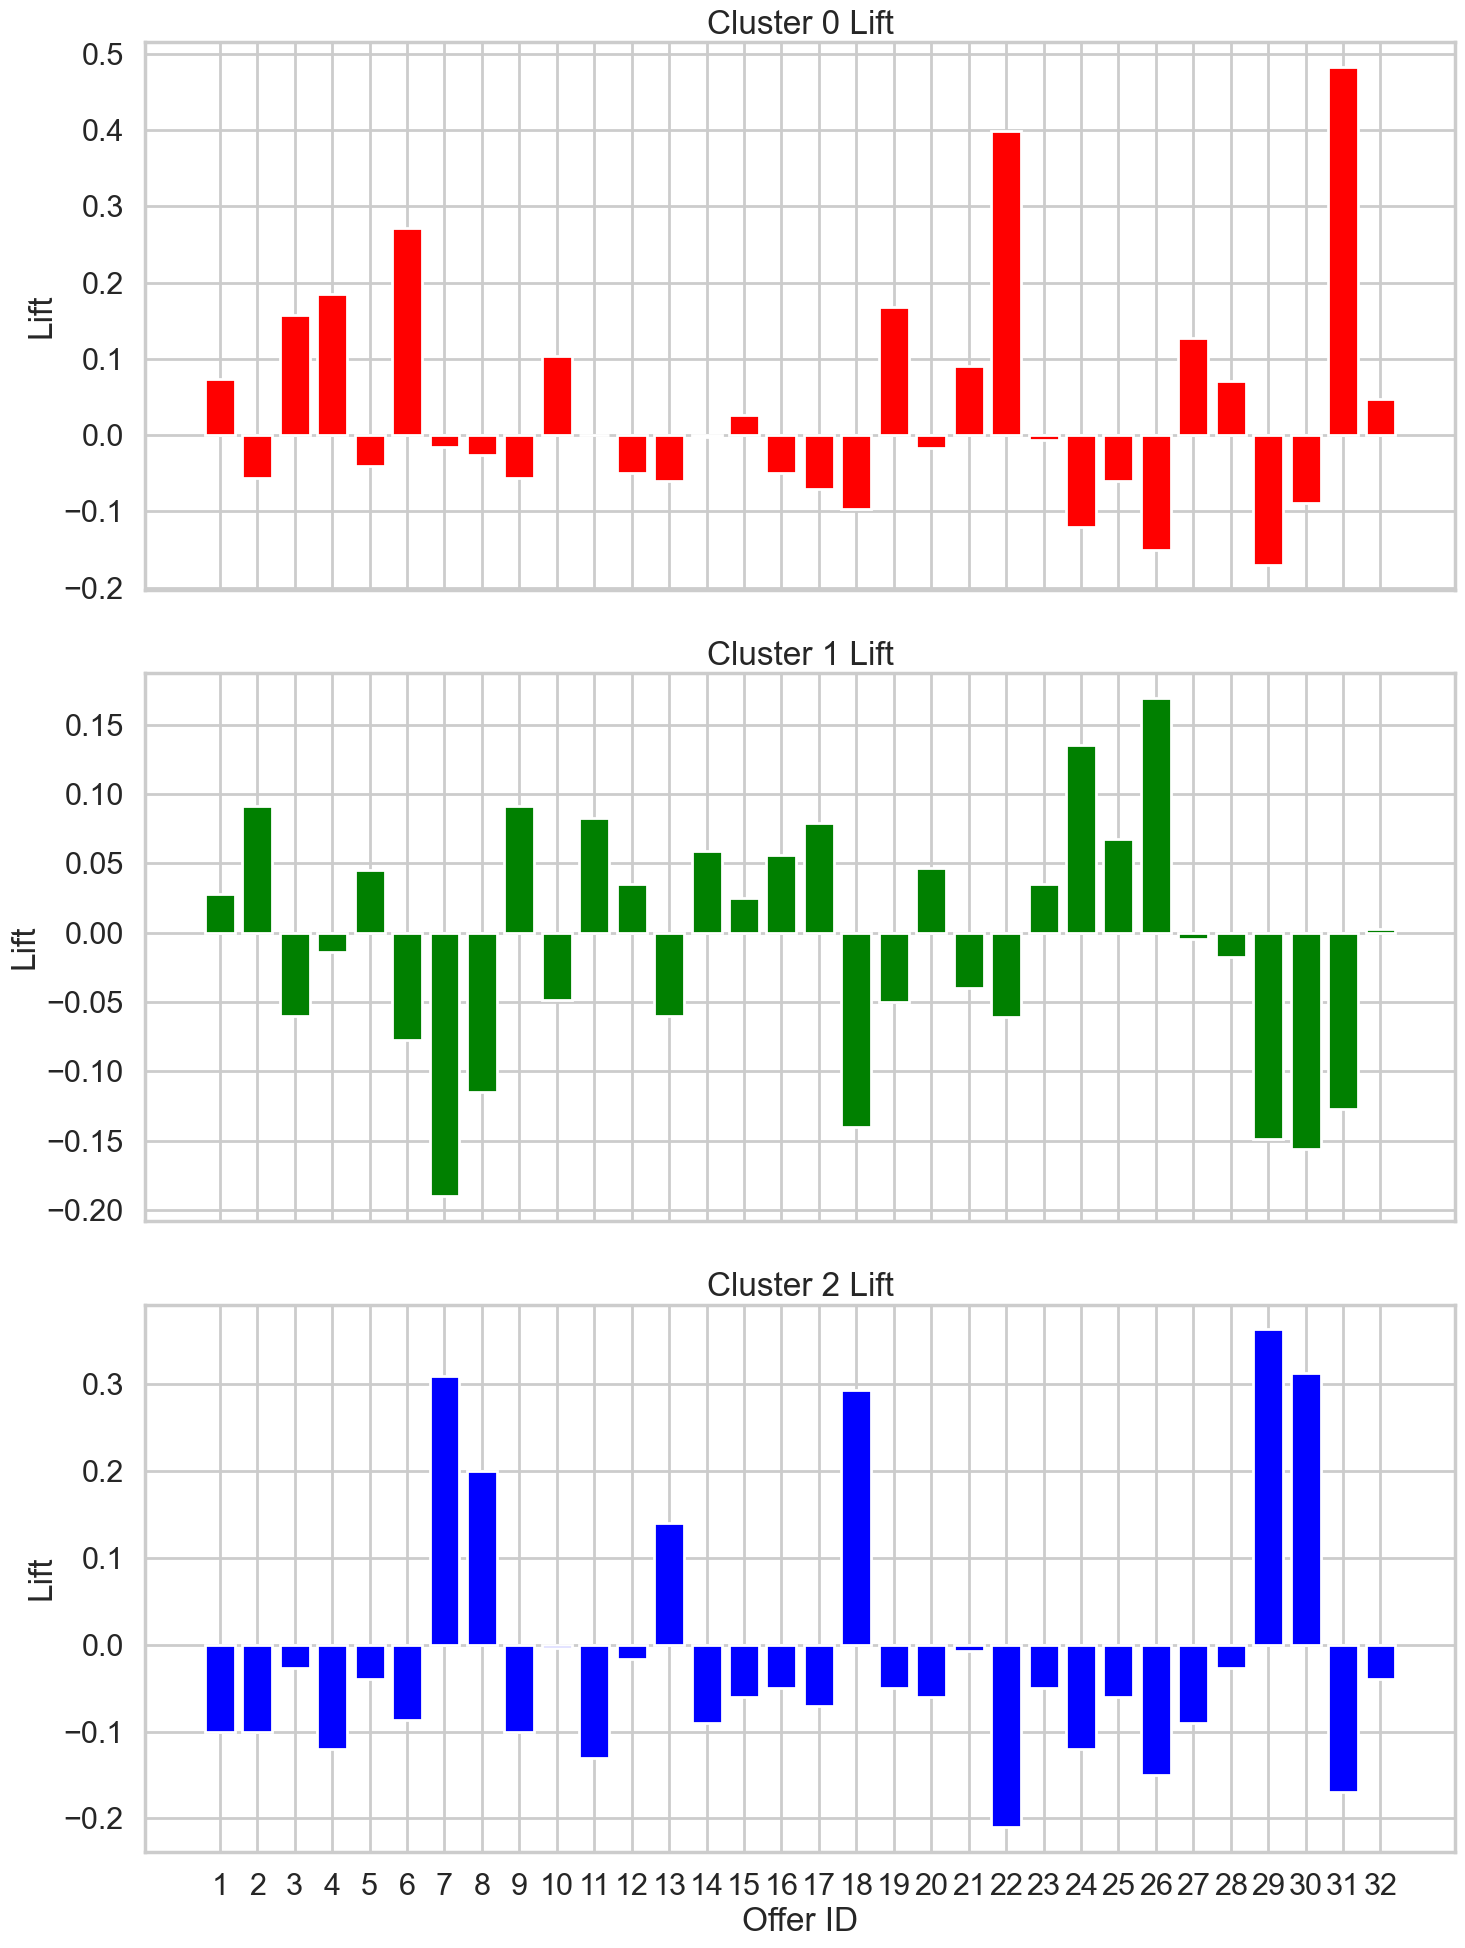

In [97]:
# Perform KMeans clustering
model = KMeans(n_clusters=3, random_state=0)
cluster_assign = model.fit_predict(offer_matrix)

# Drop the 'customer_name' column from pivot_df
pivot_no_cust = pivot_df.drop(columns='customer_name')

# Calculate the overall proportions of each offer_id
offer_proportions = pivot_no_cust.sum(axis=0) / pivot_no_cust.shape[0]

# Define colors for the clusters
colors = ['red', 'green', 'blue']
# Create subplots with shared x-axis
fig, axes = plt.subplots(3, 1, figsize=(15, 20), sharex=True)

# Iterate through each cluster
for i in range(3):
    cluster = pivot_no_cust[cluster_assign == i]
    offer_proportions_cluster = cluster.sum(axis=0) / cluster.shape[0]  # Proportions within the cluster
    lift = offer_proportions_cluster - offer_proportions  # Calculate lift
    axes[i].bar(range(1, len(offer_proportions) + 1), lift, color=colors[i])
    axes[i].set_ylabel('Lift')
    axes[i].set_title(f'Cluster {i} Lift')
    axes[i].set_xticks(range(1, len(offer_proportions) + 1))

# Set the x-axis label for the last subplot
axes[-1].set_xlabel('Offer ID')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [106]:

pivot_df['cluster_id'] = cluster_assign
display(pivot_df.head())

,customer_name,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,cluster_id
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


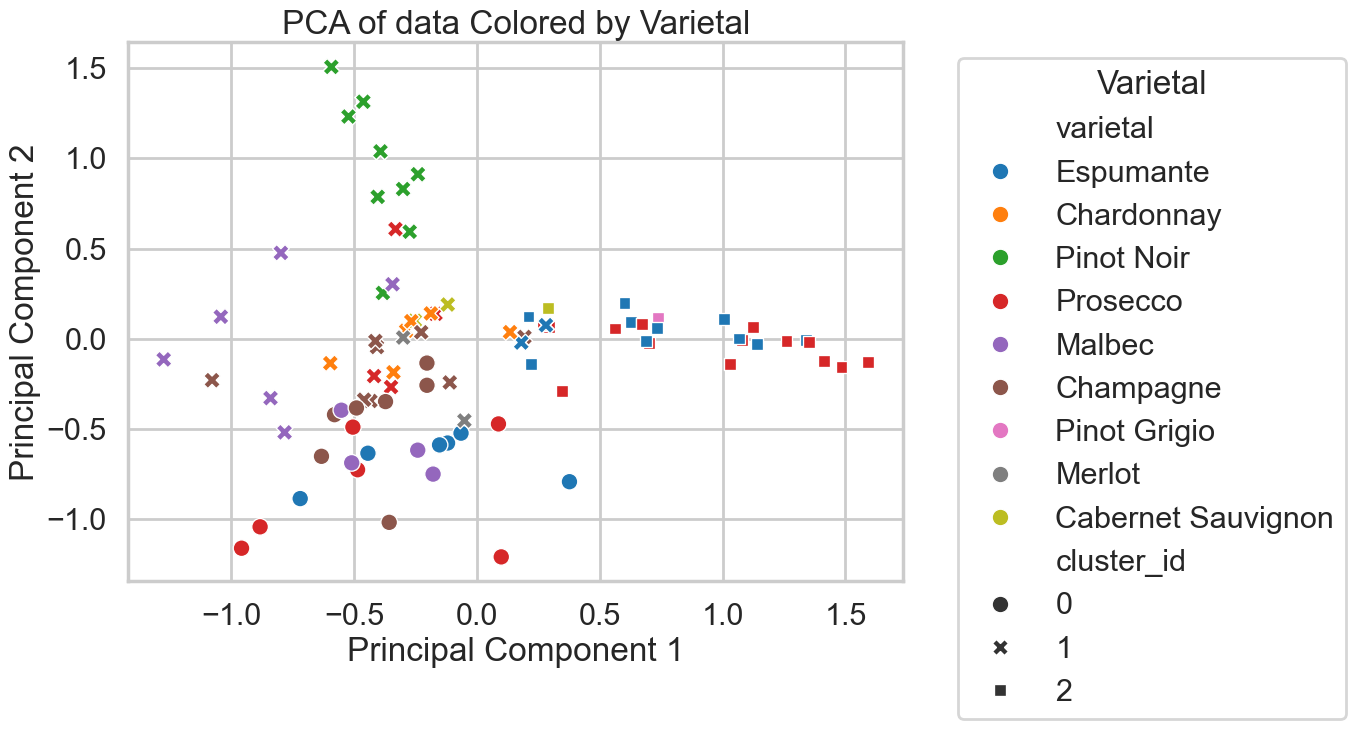

In [110]:
# Extract customer names
customer_names = pivot_df['customer_name']

# Extract the offer matrix (excluding the customer_name column)
offer_matrix = pivot_df.iloc[:, 1:-1].to_numpy()  # Exclude the 'customer_name' and 'cluster_id' columns

# Perform KMeans clustering
model = KMeans(n_clusters=3, random_state=0)
cluster_assign = model.fit_predict(offer_matrix)

# Perform PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(offer_matrix)
pc1, pc2 = zip(*pca_components)

# Create a DataFrame with the required fields
df = pd.DataFrame({
    'customer_name': customer_names,
    'cluster_id': cluster_assign,
    'x': pc1,
    'y': pc2
})

# Merge pivot_df with offers_df to get detailed offer information
merged_df = pd.melt(pivot_df, id_vars=['customer_name', 'cluster_id'], var_name='offer_id', value_name='response')
merged_df = merged_df[merged_df['response'] == 1]  # Filter only the responded offers
merged_df = pd.merge(merged_df, df_offers, on='offer_id')

# Create a mapping from offer_id to varietal
offer_to_varietal = df_offers.set_index('offer_id')['varietal'].to_dict()

# Map the varietal to each customer based on the offers they responded to
df['varietal'] = merged_df.groupby('customer_name')['varietal'].first().reindex(df['customer_name']).values

# Plot the PCA components colored by varietal
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='x', y='y', hue='varietal', style='cluster_id', palette='tab10')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of data Colored by Varietal')
plt.legend(title='Varietal', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

It does not look like any one varietal is driving a cluster- though there are a few varietals that are exclusive to a cluster- like Chardonnay and Pinot. Most clusters have >1 varietal, and some varietals are split into multiple clusters. Not too surprising as many wine drinkers enjoy more than one variety. 

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

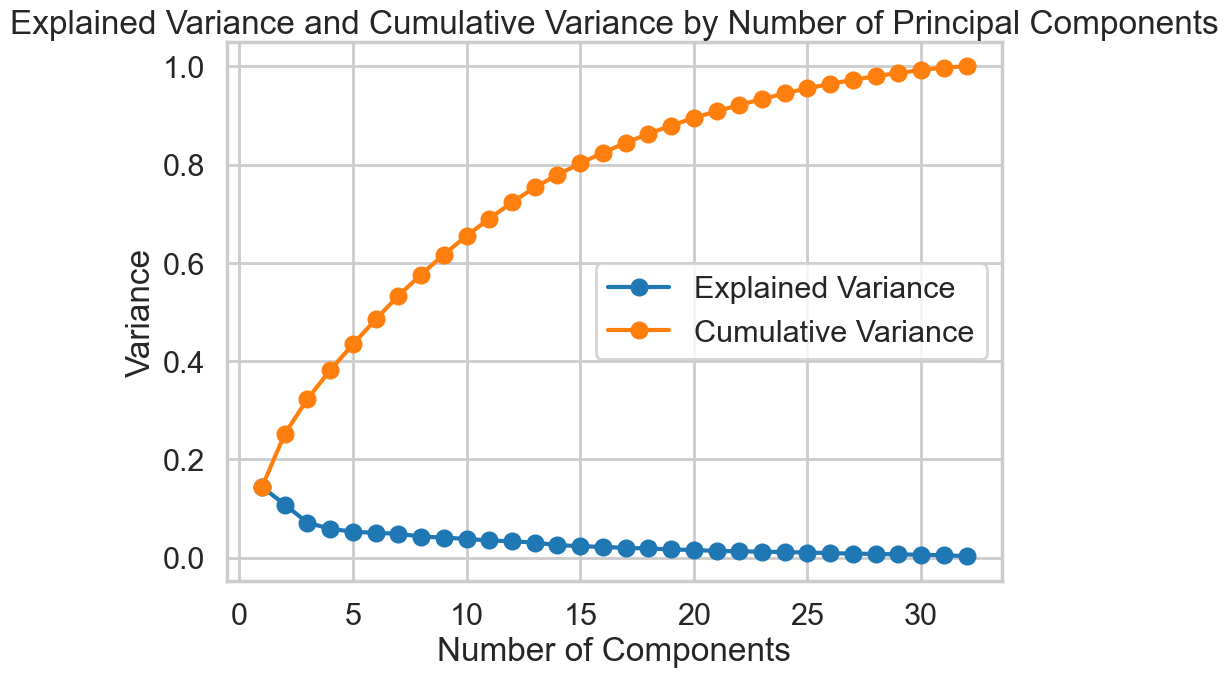

In [113]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(offer_matrix)

# Do the rest on your own :)
# Plot the explained variance
# Calculate cumulative variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 7))

# Plot explained variance for each PC
plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_ratio_, marker='o', label='Explained Variance')

# Plot cumulative variance
plt.plot(range(1, len(pca.explained_variance_) + 1), cumulative_variance, marker='o', label='Cumulative Variance')

plt.xlabel('Number of Components')
plt.ylabel('Variance')
plt.title('Explained Variance and Cumulative Variance by Number of Principal Components')
plt.legend()
plt.show()

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

## My take

I don't think we've been successful in segmenting customers. This may be a data number issue (only 100 customers). Given that we have 32 features, we may need more data to come to any firm conclusions. It takes up to 15 PCs to explain 80% of the variance- which seems like a lot (at least in my experience). Even when doing PCA for single-cell transcriptomics, it is rare to have some many PCs to get to 80% of the variance!
Additionally, even when you look at the more constrained clustering/PCA above, you don't see clear cuts by things like varietals. 

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [119]:
from sklearn.cluster import AffinityPropagation

# Your turn
X=offer_matrix
# Build and fit the Affinity Propagation model
affinity_propagation = AffinityPropagation(random_state=0)
affinity_propagation.fit(X)

# Get the cluster assignments
cluster_assignments = affinity_propagation.predict(X)
print(cluster_assignments)
affinity_prop_silhouette=silhouette_score(offer_matrix, cluster_assignments)
print("Silhoutte score for affinity matrix:", affinity_prop_silhouette)

[ 0 10  6  3  3 12  6  7  4  2  9 13  2 12  4  6  3  6  0  1  2  7  4  9
  6 10 11  4 10 13  3  7  4  8  0  5  4  2  4  5  6  6  7 12  0  8  2  3
 10  4  1 12 13  6  3  7  6  3  0  7 12  7 12  0  0 13  6 11  9 10 11 10
  8  3 12  3 13  3  0 13 11 10 11 13  2  5  0 10 10  7  8  0  3  3  1 12
  7 12  8 10]
Silhoutte score for affinity matrix: 0.12400641201174897


In [120]:
from sklearn.cluster import SpectralClustering

# Build and fit the Spectral Clustering model
spectral_clustering = SpectralClustering(n_clusters=K, random_state=0)
spectral_cluster_assignments = spectral_clustering.fit_predict(X)

print(spectral_cluster_assignments)

spectral_clust_silhouette=silhouette_score(offer_matrix, spectral_cluster_assignments)
print("Silhoutte score for spectral clustering:", spectral_clust_silhouette)

[5 4 7 9 4 0 7 2 6 9 3 7 9 0 5 7 4 7 5 6 9 2 6 3 7 0 4 4 4 7 9 2 6 1 2 8 6
 9 3 8 7 7 2 0 9 1 9 9 4 4 6 0 4 7 4 2 7 9 5 2 4 2 4 5 5 4 7 4 3 4 4 4 6 9
 4 9 7 6 5 7 4 0 4 7 2 8 5 0 4 2 1 5 4 9 6 4 2 0 1 0]
Silhoutte score for spectral clustering: 0.1242812233391928


In [122]:
from sklearn.cluster import AgglomerativeClustering

# Build and fit the Agglomerative Clustering model
agglomerative_clustering = AgglomerativeClustering(n_clusters=K)
agglomerative_cluster_assignments = agglomerative_clustering.fit_predict(X)

print(agglomerative_cluster_assignments)

agglom_clust_silhouette=silhouette_score(offer_matrix, agglomerative_cluster_assignments)
print("Silhoutte score for applomerative clustering:", agglom_clust_silhouette)

[4 0 2 8 6 6 2 9 1 8 1 2 8 7 4 2 7 2 4 0 8 9 3 1 2 5 0 7 0 2 8 4 1 3 9 4 1
 8 1 4 2 2 9 7 8 3 8 6 0 7 0 6 2 2 3 9 2 8 4 7 6 9 7 4 4 2 2 0 1 0 0 0 3 8
 6 8 2 3 4 2 5 5 0 2 8 4 8 5 0 9 3 4 7 8 0 6 8 6 3 6]
Silhoutte score for applomerative clustering: 0.09754750747147792


In [124]:
from sklearn.cluster import DBSCAN

# Build and fit the DBSCAN model
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_cluster_assignments = dbscan.fit_predict(X)

print(dbscan_cluster_assignments)

print("No point in running silhoutte score, DBSCAN considers all points noise")

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1]
No point in running silhoutte score, DBSCAN considers all points noise


# conclusion

All methods suggest there is no real structure in this data to support clustering, based on low Silhouette scores. DBSCAN didn't even try- it just considered all points noise and gave up (I kind of like this actually).